<h1>Finding the best location for a new restaurant using neighborhood clustering</h1>

<h1>1.Business Problem</h1>

As an __Argentinian__, I was surprised when I first arrived to Amsterdam. It was neither the red light district nor the great amount of coffee shops out there. The thing that __caught my attention__ was the number or __Argentinian restaurants__ I saw there. I ignore the reason for such a success, but I think it is worth to analyse the caracteristics of the neghborhood/neighborhoods where the restaurants are located to see if there is a good candidate(a similar neighborhood with less competitors) to open a new venue.
The bussiness is becaming more attractive as a new trade deal between EU and some Latin America countries(including Argentina) could lead to lower cost of raw materials.


Amsterdam has a population of 866,737 within the city proper, 1,380,872 in the urban area and 2,410,960 in the metropolitan area, which makes it a __good candidate for international restaurants__. It is broken up into 8 districts or boroughs (stadsdelen), which are further divided into neighborhoods. Moreover, According to https://www.amsterdamsights.com . the city has __more than 1325 restaurants!__ 

So, the idea is basically to cluster neighborhoods to see which are the best candidates for a ner Argentinian restaurant in the 'Venice of the North' (yeap, that is how they use to call it) 

<h1>2.Data Analysis and Cleaning</h1>

Let's start by importing all the libraries we will be using in this analysis

In [1]:
#importing the necessary libraries

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

from urllib.request import urlopen

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values


import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#to normalize demografics data
from sklearn import preprocessing

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print ('Libraries imported')



Libraries imported


Now that the libraries are imported, we can start analysing the database we will be working with a little bit. The dataset contains information about the different "barrios" (neighborhoods), their latitud and longitude, perimeter area and "comuna" (like boroughs). Let's take a look!

For this work, we are only going to need the name of the neighborhoods and the comuna which they belong to, so we can drop the other columns

In [2]:
amsterdam = pd.read_csv('https://claircitydata.cbs.nl/dataset/689ded75-1a80-4259-b033-63913573c13a/resource/d02c5f12-1cfa-4d7c-91d3-41af8e4ed634/download/wijken_buurten.csv')
amsterdam.head()

,subject,region_name,regio_type,region_code,ninhabitants,nmen,nwomen,nage_0_to_15,nage_15_to_25,nage_25_to_45,nage_45_to_65,nage_65_older,nunmarried,nmarried,ndivorced,nwidowed,nimmigrant_western,nimmigrant_nonwestern,nimmigrant_marokko,nimmigrant_antiles_aruba,nimmigrant_surinam,nimmigrant_turkey,nimmigrant_other_non_western,nhouseholds,nhh_single_person,nhh_no_children,nhh_with_children,ave_househ_size,populatio_density,area_total,area_land,area_water,urbanisation_grade,address_density,geojson,lon,lat
0,Amsterdam,Amsterdam,Gemeente,GM0363,833624,411608,422016,127224,108370,293154,204741,100135,531112,203974,73962,24576,140901,289823,75065,12227,66119,42622,93790,456462,251828,92709,111925,1.8,5042.0,21949,16533,5416,1.0,6011.0,"{""type"": ""FeatureCollection"",""crs"": { ""type"": ...",4.879568,52.381000
1,Burgwallen-Oude Zijde,Amsterdam,Wijk,WK036300,4280,2340,1935,255,675,2030,980,355,3280,660,290,65,1275,640,25,40,80,40,455,3070,2160,655,265,1.4,12255.0,40,35,6,1.0,7619.0,"{""type"": ""FeatureCollection"",""crs"": { ""type"": ...",4.896943,52.372566
2,Kop Zeedijk,Amsterdam,Buurt,BU03630000,1020,570,445,50,140,520,260,60,765,175,70,15,320,145,5,10,20,10,105,740,520,170,55,1.4,16818.0,8,6,2,1.0,6649.0,"{""type"": ""FeatureCollection"",""crs"": { ""type"": ...",4.900280,52.375937
3,Oude Kerk e.o.,Amsterdam,Buurt,BU03630001,670,365,300,30,130,320,145,55,540,70,55,15,205,105,5,10,15,10,70,500,370,95,45,1.3,7615.0,9,9,0,1.0,7361.0,"{""type"": ""FeatureCollection"",""crs"": { ""type"": ...",4.896156,52.373793
4,Burgwallen Oost,Amsterdam,Buurt,BU03630002,1610,880,730,120,250,755,340,155,1230,255,115,25,495,275,10,15,35,10,210,1120,770,260,105,1.4,25867.0,7,6,1,1.0,7544.0,"{""type"": ""FeatureCollection"",""crs"": { ""type"": ...",4.898757,52.372815


we will focus only on __Wijk__, so lets filter theese rows

In [3]:
amsterdam = amsterdam[amsterdam['regio_type']=='Wijk']
amsterdam.shape

(99, 37)

### Exploratory Data Analysis

In [4]:
amsterdam.describe() #lets see how our data looks like

,ninhabitants,nmen,nwomen,nage_0_to_15,nage_15_to_25,nage_25_to_45,nage_45_to_65,nage_65_older,nunmarried,nmarried,ndivorced,nwidowed,nimmigrant_western,nimmigrant_nonwestern,nimmigrant_marokko,nimmigrant_antiles_aruba,nimmigrant_surinam,nimmigrant_turkey,nimmigrant_other_non_western,nhouseholds,nhh_single_person,nhh_no_children,nhh_with_children,ave_househ_size,populatio_density,area_total,area_land,area_water,urbanisation_grade,address_density,lon,lat
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,98.000000,98.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,8418.383838,4155.909091,4260.707071,1286.262626,1095.909091,2962.171717,2069.191919,1012.626263,5367.121212,2062.525253,749.090909,250.050505,1424.292929,2928.585859,759.343434,124.393939,668.888889,431.565657,948.535354,4608.838384,2545.555556,938.737374,1132.676768,1.813265,11035.459184,198.343434,167.000000,31.414141,1.404040,5437.727273,4.890652,52.364190
std,5590.378023,2753.443610,2845.012196,1055.084711,835.137580,1931.511801,1493.030357,763.344996,3599.645185,1468.309519,620.966726,214.884277,933.620616,3399.740014,1041.625899,225.759797,1304.880860,648.338790,1132.096270,3009.829800,1768.873573,579.527140,892.404546,0.328583,7981.630281,404.903596,323.660852,98.335537,0.891218,3381.841401,0.054977,0.025439
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.100000,10.000000,17.000000,17.000000,0.000000,1.000000,260.000000,4.775212,52.296161
25%,3882.500000,1880.000000,1905.000000,450.000000,550.000000,1550.000000,940.000000,435.000000,2990.000000,895.000000,322.500000,90.000000,725.000000,675.000000,55.000000,35.000000,122.500000,55.000000,345.000000,2607.500000,1337.500000,442.500000,442.500000,1.600000,5100.000000,50.500000,44.000000,4.000000,1.000000,2555.500000,4.855333,52.350196
50%,7980.000000,4115.000000,4055.000000,1080.000000,940.000000,3025.000000,1880.000000,880.000000,5190.000000,1830.000000,705.000000,220.000000,1355.000000,1765.000000,330.000000,80.000000,365.000000,170.000000,775.000000,4560.000000,2495.000000,965.000000,950.000000,1.700000,9685.000000,107.000000,96.000000,8.000000,1.000000,4811.000000,4.890582,52.363502
75%,11940.000000,5770.000000,6212.500000,1752.500000,1512.500000,4005.000000,2877.500000,1445.000000,7385.000000,2940.000000,1007.500000,357.500000,1932.500000,3765.000000,990.000000,130.000000,710.000000,495.000000,1197.500000,6312.500000,3482.500000,1317.500000,1522.500000,2.000000,15089.000000,170.000000,156.000000,20.000000,1.000000,8304.500000,4.927350,52.379722
max,27190.000000,13570.000000,13620.000000,4890.000000,4675.000000,8280.000000,7540.000000,3265.000000,17360.000000,5635.000000,3860.000000,1025.000000,4680.000000,18745.000000,4860.000000,1535.000000,8765.000000,3605.000000,7625.000000,14310.000000,8750.000000,2525.000000,4440.000000,2.600000,28338.000000,2899.000000,2481.000000,901.000000,5.000000,11959.000000,5.015088,52.421728


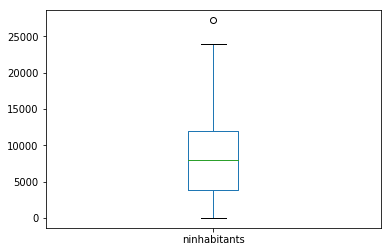

In [5]:
amsterdam['ninhabitants'].plot(kind='box')
plt.show()

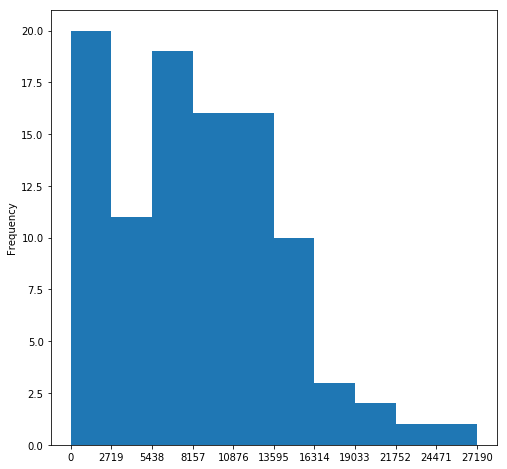

NameError: name 'savefig' is not defined

In [7]:
count,bin_edges = np.histogram(amsterdam['ninhabitants'])
amsterdam['ninhabitants'].plot(kind='hist', xticks=bin_edges, figsize = (8,8))
plt.show()

looks like we have a couple of neighborhoods with 0 habitants, lets get rid of them

In [53]:
amsterdam = amsterdam[amsterdam['ninhabitants']>amsterdam['ninhabitants'].quantile(0.10)]
amsterdam.shape
amsterdam.reset_index(inplace=True)

Now it looks much better! we could also reduce the columns of our DataFrame, since we are not going to work with all of them. In fact, for our analysis, the number of habitants and maybe some age partitioning would be enough

In [54]:
amsterdam_clean= amsterdam[['subject','lat','lon','ninhabitants','nmen','nwomen','nage_0_to_15','nage_15_to_25','nage_25_to_45','nage_45_to_65','nage_65_older']]
amsterdam_clean.columns = ['Neighborhood','Latitude','Longitude','Habitants','Male_habitants','Female_habitants','Age_0_to_15','Age_15_to_25','Age_25_to_45','Age_45_to_65','Age_65_older']

amsterdam_clean.head(10)
amsterdam_clean.shape


(89, 11)

We can se how our data looks up to now. lets use folium to plot them!

In [55]:
address = 'Amsterdam, NL'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude =location.latitude
longitude = location.longitude

In [56]:
# create map of New York using latitude and longitude values
amst_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng,neighborhood in zip(amsterdam_clean['Latitude'], amsterdam_clean['Longitude'],  amsterdam_clean['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        location = (lat, lng),
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(amst_map)  
    
amst_map

I will use __Foursquare API__ to explore the boroughs and segment them. I designed the limit as __100 venues__ and the radius __700 meters__ for each neighborhood from their given latitude and longitude informations.

In [57]:
CLIENT_ID = 'U3QPFGLFOQHSUBCUCFL3LUFQWXM3GBJAIBIYH3UG31NRHSOM' # your Foursquare ID
CLIENT_SECRET = 'Q0KKTD24X0NUGIESXKEHZPRJ1TGR2FDSXRGR1AS4BJF2BDON' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


In [58]:
def getNearbyVenues(names, latitudes, longitudes, radius=700, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
    
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

And now I will use the function we just created to get the venues

In [59]:
amsterdam_venues = getNearbyVenues(names=amsterdam_clean['Neighborhood'],
                                   latitudes=amsterdam_clean['Latitude'],
                                   longitudes=amsterdam_clean['Longitude']
                                  )

check the shape of our DataFrame

In [60]:
amsterdam_venues.shape

(4692, 7)

In [61]:
print('There are {} uniques categories.'.format(len(amsterdam_venues['Venue Category'].unique())))  #show see how many types of venues do we have

There are 308 uniques categories.


Lets analyse each neghborhood in detail

In [62]:
# one hot encoding
amsterdam_onehot = pd.get_dummies(amsterdam_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
amsterdam_onehot['Neighborhood'] = amsterdam_venues['Neighborhood'] 

# move neighborhood column to the first column
neigh_index = amsterdam_onehot.columns.get_loc('Neighborhood')
columns_index = list(range(len(amsterdam_onehot.columns)))
columns_index.remove(neigh_index)
fixed_columns = [amsterdam_onehot.columns[neigh_index]] + list(amsterdam_onehot.columns[columns_index])
amsterdam_onehot = amsterdam_onehot[fixed_columns]

amsterdam_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Baseball Field,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brasserie,Breakfast Spot,Brewery,Bridal Shop,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Campground,Canal,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cruise,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Doner Restaurant,Drugstore,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Field,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Nightclub,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Piano Bar,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Restaurant,Road,Rock Climbing Spot,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Club,Stables,Stadium,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tanning Salon,Tapas Res

In [63]:
amsterdam_grouped = amsterdam_onehot.groupby('Neighborhood').mean().reset_index() 


Now I will create a function to help me sort the most common venues per neighborhood

In [64]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [65]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = amsterdam_grouped['Neighborhood']

for ind in np.arange(amsterdam_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(amsterdam_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Apollobuurt,Hotel,Italian Restaurant,Park,Art Gallery,French Restaurant,Juice Bar,Basketball Court,Cocktail Bar,Supermarket,Steakhouse
1,Banne Buiksloot,Bus Stop,Bakery,Supermarket,Monument / Landmark,Shopping Mall,Restaurant,Sports Club,Park,Turkish Restaurant,Stables
2,Betondorp,Park,Bakery,Bus Stop,Soccer Field,Café,Museum,Music Venue,Empanada Restaurant,Ethiopian Restaurant,Event Space
3,"Bijlmer Centrum (D,F,H)",Chinese Restaurant,Bakery,Park,Hotel,Clothing Store,Fast Food Restaurant,Coffee Shop,Asian Restaurant,Supermarket,Italian Restaurant
4,"Bijlmer Oost (E,G,K)",Supermarket,Bus Stop,Discount Store,Turkish Restaurant,Bakery,Drugstore,Chinese Restaurant,Farmers Market,Burger Joint,Bar


I will now merge the two DataFrames to get all our variables in one place

In [66]:
amsterdam_exhaustive = pd.merge(amsterdam_grouped,amsterdam_clean, how='left', on = 'Neighborhood')
amsterdam_exhaustive.describe()

,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Baseball Field,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brasserie,Breakfast Spot,Brewery,Bridal Shop,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Campground,Canal,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cruise,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Doner Restaurant,Drugstore,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Field,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Nightclub,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Piano Bar,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Restaurant,Road,Rock Climbing Spot,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Club,Stables,Stadium,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tatto

In [67]:
#data preparation for the analysis
X=amsterdam_exhaustive
X.drop(['Neighborhood'],axis=1,inplace=True)
X.shape
X = X.values


In [68]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))

### 3.Cluster Neighborhoods

We are now ready to start clustering our neighborhoods! 

In [69]:
# set number of clusters
kclusters = 5


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 1, 1, 1, 1, 2, 1, 2, 1], dtype=int32)

In [70]:
amsterdam_grouped['class'] = kmeans.labels_
amsterdam_grouped.head()
to_paste = amsterdam_grouped[['Neighborhood','class']]

In [71]:
final = pd.merge(amsterdam_grouped,to_paste, how='left', on = 'Neighborhood')
final_to_plot = pd.merge(amsterdam_clean,to_paste, how='left', on = 'Neighborhood')

In [72]:
#preprocessing to plot
final_to_plot.dropna(axis = 0, inplace = True)
final_to_plot = final_to_plot.astype({"class": int})
final_to_plot.dtypes

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Baseball Field,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brasserie,Breakfast Spot,Brewery,Bridal Shop,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Campground,Canal,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cruise,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Doner Restaurant,Drugstore,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Field,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Nightclub,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Piano Bar,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Restaurant,Road,Rock Climbing Spot,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Club,Stables,Stadium,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tanning Salon,Tapas Res

Finally, lets sort our data by __'Argentinian Restaurant'__ , so we can know what is the class we are most interested in

In [ ]:
final.sort_values(by='Argentinian Restaurant', ascending=False).head()

In [73]:
#get latitude and longitude to plot data
address = 'Amsterdam, NL'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude =location.latitude
longitude = location.longitude
# create map


map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(final_to_plot['Latitude'], final_to_plot['Longitude'], final_to_plot['Neighborhood'], final_to_plot['class']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

TypeError: list indices must be integers or slices, not float

Lets plot our data in a folium map so we can get a visual idea about how our data is clustered

Lets plot our data in a folium map so we can get a visual idea about how our data is clustered